## Sequential decision making with evaluative feedback

In RL, the agent generates its own training data by interacting with the world. The agent must learn the consequences of its own actions through trials and errors rather than being told the correct actions.

**The K-armed bandit problem**

In a k-armed bandit problem, we have an **agent** who chooses between $k$ **actions** and receives a **reward** based on the action it chooses.

**Action-Values**

For the agent decides which action is best, we must define a velue of taking each action called **action-values function**.

- The **value** is the **expected reward** the agent receives when taking an action.

$$q_*(a) \; \dot{=} \; \mathbb{E}[R_t|A_t=a] \;\; \forall a \in \{1, ..., k\} \\
= \sum_r p(r|a) \; r$$

- The goal of the agent is to **maximize** the **expected reward** by selecting the action that have the highest value.

$$argmax_a \; q_*(a)$$

## Learning Action-Values

The objective is to **estimate** $Q(a) \rightarrow q_*(a)$.

**Sample-Average Method**

One way to estimate $q_*(a)$ is to compute a sample average:

$$Q_t(a) \; \dot{=} \; \frac{\sum_{i=1}^{t-1}R_i \; I[A_i = a]}{\sum_{i=1}^{t-1}\; I[A_i = a]}$$

If the denominator is $0$, we defined $Q(a)$ at some default value such as $0$.

As $\sum_{i=1}^{t-1}\; I[A_i = a] \rightarrow +\infty$, $\;Q_t(a) \rightarrow q_*(a)$ (*Law of large numbers*).

The sample-average method is not necessarily the best one for selecting action-values.

Calculating $Q_t(a)$ by using the formula above implies memory and computational requirements which increase as $t$ increases. So, we  use an **incremental implementation**

Let's $Q_n = \frac{R_1 + R_2 + ... + R_{n-1}}{n - 1}$

$$\Rightarrow Q_{n + 1} = \frac{1}{n} \sum_{i=1}^n R_i = \frac{1}{n} [R_n + \sum_{i=1}^{n-1} R_i] = \frac{1}{n} [R_n + (n - 1) \frac{1}{n-1} \sum_{i=1}^{n-1} R_i] = \frac{1}{n} [R_n + (n-1)Q_n] = \frac{1}{n} (R_n + nQ_n  - Q_n) = Q_n + \frac{1}{n} (R_n - Q_n)$$

We obtain the update rule: **New Estimate $\leftarrow$ Old Estimate + Step Size [Target - Old Estimate]**

Step Size = $\alpha = \alpha_t(a) = \frac{1}{n} \in [0, 1)$

**Tracking non-stationary problem - Exponential recency-weighted average**

When the probability of reward changes over time (in most RL problems), it makes sense to give more weight to recent rewards than to long-past rewards.

$$Q_{n+1} = Q_n + \alpha (R_n - Q_n) = \alpha R_n + (1 - \alpha) Q_n = \alpha R_n + (1 - \alpha) [\alpha R_{n-1} + (1 - \alpha) Q_{n - 1}] = \alpha R_n + (1 - \alpha) \alpha R_{n - 1} + (1 - \alpha)^2 Q_{n - 1} = \alpha R_n + (1 - \alpha) \alpha R_{n - 1} + (1 - \alpha)^2 [\alpha R_{n-2} + (1 - \alpha) Q_{n - 2}] = \alpha R_n + (1 - \alpha) \alpha R_{n - 1} + (1 - \alpha)^2 \alpha R_{n - 2} + (1 - \alpha)^3 Q_{n - 2} = \;...$$
$$\Rightarrow Q_{n+1} = (1 - \alpha)^n Q_1 + \sum_{i=1}^n \alpha (1 - \alpha)^{n-i}R_i$$

The convergence is guarantedd with $\alpha_n(a) = \frac{1}{n}$.

Sometimes, it is convenient to change $\alpha_n(a)$ from step to step. But of course convergence is guaranteed for all choices of the sequence $\{\alpha_n(a)\}$.

A well-known result in stochastic approximation theory gives us the conditions required to ensure convergence with probability 1:

1. $\sum_{n=1}^\infty \alpha_n(a) = \infty$ guaranteed that the steps are large enough to eventually overcome any init conditions or random fluctuations.
2. $\sum_{n=1}^\infty \alpha_n(a) < \infty$ guaranteed that eventually the steps become small enough to ensure convergence.

These conditions are **true** with $\alpha_n(a) = \frac{1}{n}$ but **false** for the case of constant stepsize param $\alpha$ (which is desirable in non-stationary environments).

**Action selection**

- **Greedy action selection** (low reward variance): the agent always exploits its current knowledge to maximize the immediate reward.

$$A_t = argmax_a \; Q_t(a)$$

- **$\varepsilon$-greedy action selection** (high reward variance): every once in a while, the agent an action with a small probability $\varepsilon$. Every action will be sampled an infinite number of time as the number of steps increase. Thus, $Q_t(a) \rightarrow q_*(a) \Rightarrow P(a_t^*) \rightarrow 1 - \varepsilon$.

If the reward function is non-stationary (doesn't change over time), the exploration is needed i.e $\varepsilon$-greedy action selection.

## Exploration vs Exploitation tradeoff

The tradeoff is simply the way the agent decides when its takes the best action (according to its current knowledge) - exploitation or try something else (random) exploration. If the agent never chooses a particular action, it won't know its value.

- **Exploration**: *improve* knowledge for *long-term* benefit.

- **Exploitation**: *exploit* knowledge for *short-term* benefit.

When we explore, we get more accurate estimate of our values, when we exploit, we might get more reward. We cannot however choose to do both simultaneously.

A simple method to choose between exploration and exploitation is to use **$\varepsilon$-greedy action selection**. Other methods are **optimistic initial values** and **Upper-Confidence Bound (UCB) action selection**.

**Optimistic initial values**

All methods discussed so far depend on init value $Q_1(a)$. These methods are **biased** since we use the statistic mean. The bias disappears with sampled average and is constant with fixed value of $\alpha$.

In practice, it's not usually a problem and can sometimes be very helpfull.

**Limitations of optimistic initial values**

- Only drives early exploration.
- Not well-suited for non-stationary problems.
- Sometimes, it's difficult to know what the optimistic initial values should be. Then, we have to tune them.

**Upper-Confidence Bound (UCB) action selection**

UCB action selection uses **uncertainty** in the value estimates for balancing exploration and exploitation.

In other words, it would be better to select among non-greedy actions according to their potential for being actually optimal taking into account:

- How close the estimates are being max.
- The uncertainties in those estimates.

One effetive way to do that is:

$$A_t = argmax_a [Q_t(a) + c \sqrt{\frac{\ln t}{N_t(a)}}]$$

Where $N_t(a)$ is the number of time the action $a$ is selected at time step $t$ and $c$ control the exploration.

UCB action selection always performs well than $\varepsilon$-greedy action selection but it's **more difficult** to extend to more general RL problems:

- Deal with non-stationary problems.
- Deal with large state spaces particularly using function approximation.

In these more advanced settings, UCB action selection is usually not practical.

## Implementation of Bandit Algorithm - 10-armed Bandit Problem

We can describe the problem as follow:

An agent is faced repeatedly with a choice among $10$ different options, or actions. After each choice it receives a numerical reward chosen from a stationary probability distribution that depends on the action selected. The objective is to maximize the expected total reward over some time period, for example (*over 1000 action selections, or time steps*).

In [8]:
import time
import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from rl_glue import RLGlue
import main_agent
import ten_arm_env

### Argmax function

First, we are going to implement an `argmax` function in order to get the best action value. Numpy's argmax function returns the first instance of the highest value. We do not want that to happen as it biases the agent to choose a specific action in the case of ties. Instead we want to break ties between the highest values randomly. So we are going to implement our own argmax function. You may want to look at np.random.choice to randomly select from a list of values.

In [3]:
def argmax(q_values: np.array):
    """
    Return the argmax of q_values. If there's ties, we randomly select one of 
    them.

    Args:
        q_values: np.array
            The action values
    
    Returns: int
        The index representing the action to be taken
    """
    max_q = float('-inf')
    ties = []
    for index, q_value in enumerate(q_values):
        if q_value >= max_q:
            if q_value == max_q:
                ties.append(index)
            else:
                ties = [index]
            max_q = q_value
    return ties[np.random.choice(len(ties))]

### Agents

***Greedy agent***

In [9]:
class GreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
        action = argmax(self.q_values)
        self.arm_count[self.last_action] += 1
        self.q_values[self.last_action] += (
            1 / self.arm_count[self.last_action]
        ) * (reward - self.q_values[self.last_action])
        self.last_action = action
        return action

In [12]:
def test_greedy_agent():
    greedy_agent = GreedyAgent()
    greedy_agent.q_values = [0, 0, 1.0, 0, 0]
    greedy_agent.arm_count = [0, 1, 0, 0, 0]
    greedy_agent.last_action = 1
    action = greedy_agent.agent_step(1, 0)
    print("Output:")
    print(greedy_agent.q_values)
    print("Expected Output:")
    print([0, 0.5, 1.0, 0, 0])

    assert action == 2, "Check that you are using argmax to choose the action with the highest value."
    assert greedy_agent.q_values == [0, 0.5, 1.0, 0, 0], "Check that you are updating q_values correctly."

test_greedy_agent()

Output:
[0, 0.5, 1.0, 0, 0]
Expected Output:
[0, 0.5, 1.0, 0, 0]


100%|██████████| 200/200 [00:03<00:00, 65.47it/s]


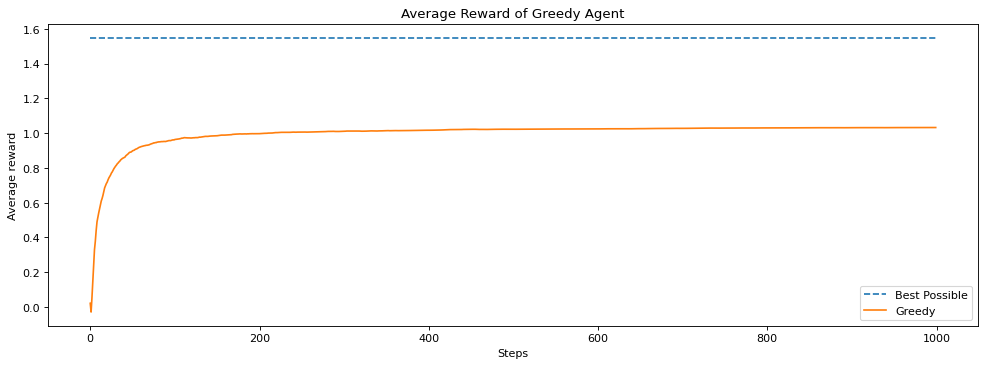

In [13]:
# Plot Greedy Result
num_runs = 200                    # The number of times we run the experiment
num_steps = 1000                  # The number of steps each experiment is run for
env = ten_arm_env.Environment     # We the environment to use
agent = GreedyAgent               # We choose what agent we want to use
agent_info = {"num_actions": 10}  # Pass the agent the information it needs; 
                                  # here it just needs the number of actions (number of arms).
env_info = {}                     # Pass the environment the information it needs; in this case, it is nothing.

all_averages = []

for i in tqdm.tqdm(range(num_runs)):      # tqdm is what creates the progress bar below once the code is run
    rl_glue = RLGlue(env, agent)          # Creates a new RLGlue experiment with the env and agent we chose above
    rl_glue.rl_init(agent_info, env_info) # Pass RLGlue what it needs to initialize the agent and environment
    rl_glue.rl_start()                    # Start the experiment

    scores = [0]
    averages = []
    
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Best Possible", "Greedy"])
plt.title("Average Reward of Greedy Agent")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()
greedy_scores = np.mean(all_averages, axis=0)

***Epsilon Greedy Agent***

In [18]:
class EpsilonGreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.q_values.size)
        else:
            action = argmax(self.q_values)
        self.arm_count[self.last_action] += 1
        self.q_values[self.last_action] += (
            1 / self.arm_count[self.last_action]
        ) * (reward - self.q_values[self.last_action])
        self.last_action = action
        return action

In [19]:
def test_epsilon_greedy_agent():
    e_greedy_agent = EpsilonGreedyAgent()
    e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
    e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
    e_greedy_agent.num_actions = 5
    e_greedy_agent.last_action = 1
    e_greedy_agent.epsilon = 0.5
    action = e_greedy_agent.agent_step(1, 0)
    print("Output:")
    print(e_greedy_agent.q_values)
    print("Expected Output:")
    print([0, 0.5, 1.0, 0, 0])

    # assert action == 2, "Check that you are using argmax to choose the action with the highest value."
    assert e_greedy_agent.q_values == [0, 0.5, 1.0, 0, 0], "Check that you are updating q_values correctly."

test_epsilon_greedy_agent()

Output:
[0, 0.5, 1.0, 0, 0]
Expected Output:
[0, 0.5, 1.0, 0, 0]


100%|██████████| 200/200 [00:03<00:00, 62.88it/s]


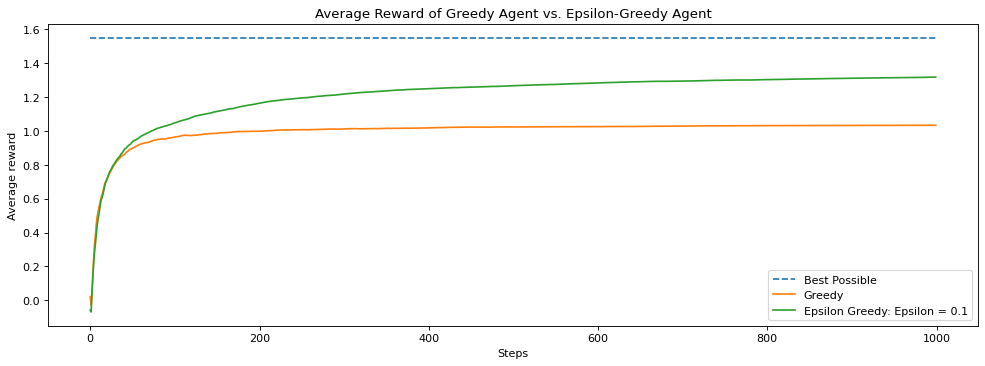

In [21]:
num_runs = 200
num_steps = 1000
epsilon = 0.1
agent = EpsilonGreedyAgent
env = ten_arm_env.Environment
agent_info = {"num_actions": 10, "epsilon": epsilon}
env_info = {}
all_averages = []

for i in tqdm.tqdm(range(num_runs)):
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    scores = [0]
    averages = []
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")
plt.plot(greedy_scores)
plt.title("Average Reward of Greedy Agent vs. Epsilon-Greedy Agent")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(("Best Possible", "Greedy", "Epsilon Greedy: Epsilon = 0.1"))
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

**Averaging Multiple Runs**

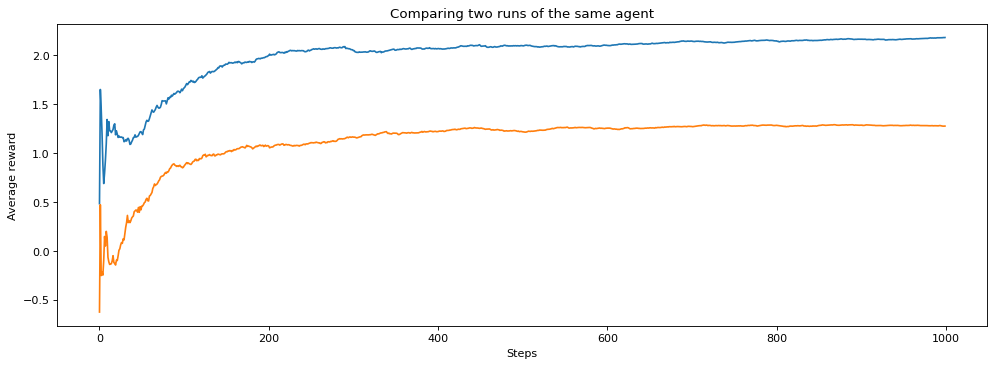

In [24]:
agent = EpsilonGreedyAgent
agent_info = {"num_actions": 10, "epsilon": 0.1}
env_info = {}
all_averages = []
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
num_steps = 1000

for run in (0, 1):
    np.random.seed(run) # Here we set the seed so that we can compare two different runs
    averages = []
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    scores = [0]
    for i in range(num_steps):
        reward, state, action, is_terminal = rl_glue.rl_step()
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    plt.plot(averages)

plt.title("Comparing two runs of the same agent")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

**Comparing values of epsilon - Exploration/Exploitation Tradeoff**

100%|██████████| 200/200 [00:02<00:00, 67.38it/s]


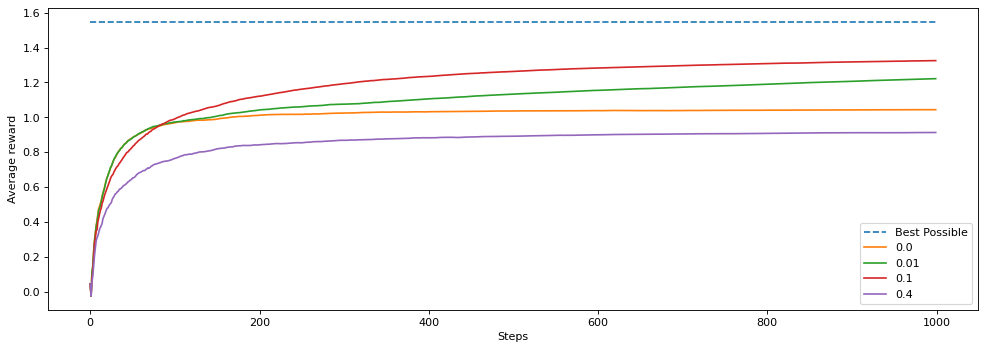

In [26]:
epsilons = [0.0, 0.01, 0.1, 0.4]

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

n_q_values = []
n_averages = []
n_best_actions = []

num_runs = 200

for epsilon in epsilons:
    all_averages = []
    for run in tqdm.tqdm(range(num_runs)):
        agent = EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon}
        env_info = {"random_seed": run}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []
        best_action_chosen = []
        
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if epsilon == 0.1 and run == 0:
                n_q_values.append(np.copy(rl_glue.agent.q_values))
        if epsilon == 0.1:
            n_averages.append(averages)
            n_best_actions.append(best_action_chosen)
        all_averages.append(averages)
        
    plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Best Possible"] + epsilons)
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

***The Effect of Step Size - Epsilon-Greedy Agent with Constant Step-size***

In [31]:
class EpsilonGreedyAgentWithConstantStepSize(main_agent.Agent):
    def agent_step(self, reward, observation):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.q_values.size)
        else:
            action = argmax(self.q_values)
        self.q_values[self.last_action] += self.step_size \
            * (reward - self.q_values[self.last_action])
        self.last_action = action
        return action

In [32]:
def test_epsilon_greedy_agent_with_constant_step_size():
    for step_size in [0.01, 0.1, 0.5, 1.0]:
        e_greedy_agent = EpsilonGreedyAgentWithConstantStepSize()
        e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
        # e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
        e_greedy_agent.num_actions = 5
        e_greedy_agent.last_action = 1
        e_greedy_agent.epsilon = 0.0
        e_greedy_agent.step_size = step_size
        action = e_greedy_agent.agent_step(1, 0)
        print("Output for step size: {}".format(step_size))
        print(e_greedy_agent.q_values)
        print("Expected Output:")
        print([0, step_size, 1.0, 0, 0])
        assert e_greedy_agent.q_values == [0, step_size, 1.0, 0, 0], "Check that you are updating q_values correctly using the stepsize."

test_epsilon_greedy_agent_with_constant_step_size()

Output for step size: 0.01
[0, 0.01, 1.0, 0, 0]
Expected Output:
[0, 0.01, 1.0, 0, 0]
Output for step size: 0.1
[0, 0.1, 1.0, 0, 0]
Expected Output:
[0, 0.1, 1.0, 0, 0]
Output for step size: 0.5
[0, 0.5, 1.0, 0, 0]
Expected Output:
[0, 0.5, 1.0, 0, 0]
Output for step size: 1.0
[0, 1.0, 1.0, 0, 0]
Expected Output:
[0, 1.0, 1.0, 0, 0]


100%|██████████| 200/200 [00:03<00:00, 66.07it/s]


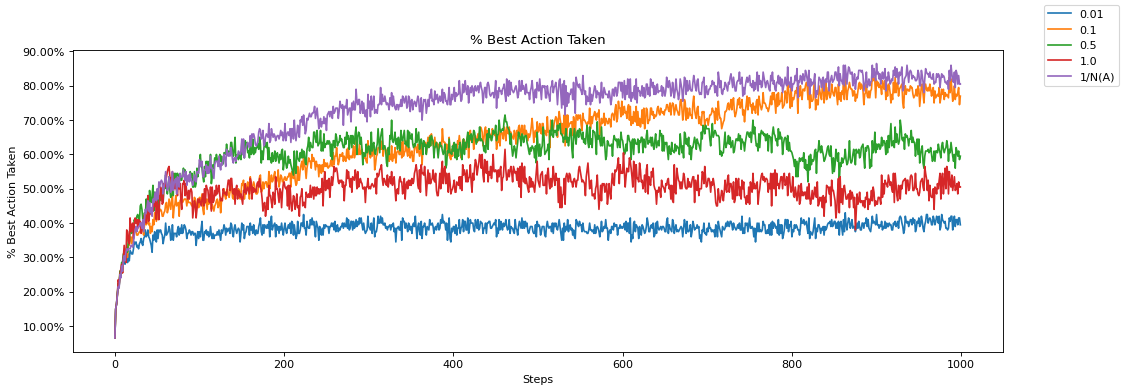

In [33]:
step_sizes = [0.01, 0.1, 0.5, 1.0]

epsilon = 0.1
num_steps = 1000
num_runs = 200

fig, ax = plt.subplots(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

q_values = {step_size: [] for step_size in step_sizes}
true_values = {step_size: None for step_size in step_sizes}
best_actions = {step_size: [] for step_size in step_sizes}

for step_size in step_sizes:
    all_averages = []
    for run in tqdm.tqdm(range(num_runs)):
        agent = EpsilonGreedyAgentWithConstantStepSize
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size, "initial_value": 0.0}
        env_info = {"random_seed": run}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []
        
        if run == 0:
            true_values[step_size] = np.copy(rl_glue.environment.arms)
            
        best_action_chosen = []
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if run == 0:
                q_values[step_size].append(np.copy(rl_glue.agent.q_values))
        best_actions[step_size].append(best_action_chosen)
    ax.plot(np.mean(best_actions[step_size], axis=0))
    if step_size == 0.01:
        np.save("step_size", best_actions[step_size])
    
ax.plot(np.mean(n_best_actions, axis=0))
fig.legend(step_sizes + ["1/N(A)"])
plt.title("% Best Action Taken")
plt.xlabel("Steps")
plt.ylabel("% Best Action Taken")
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

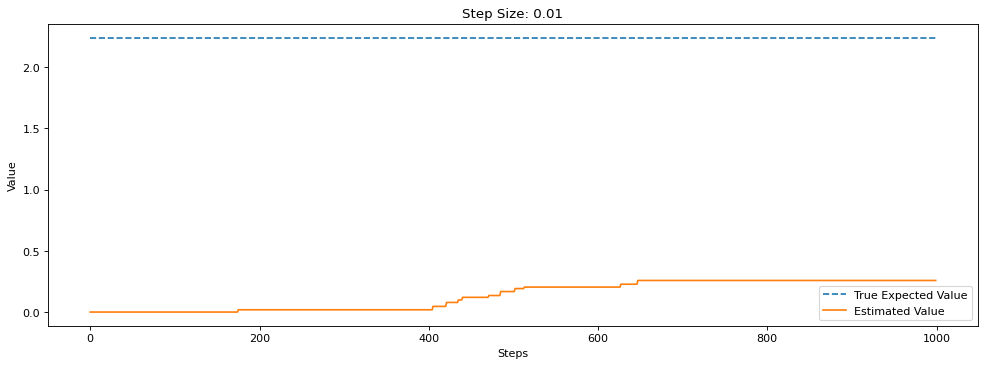

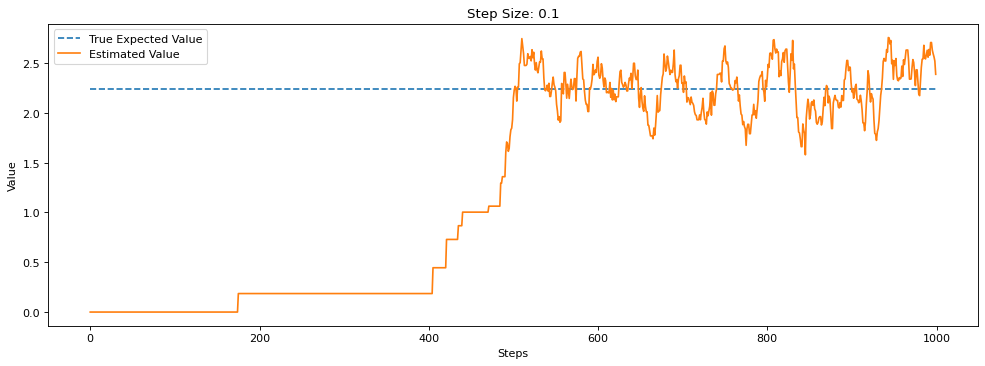

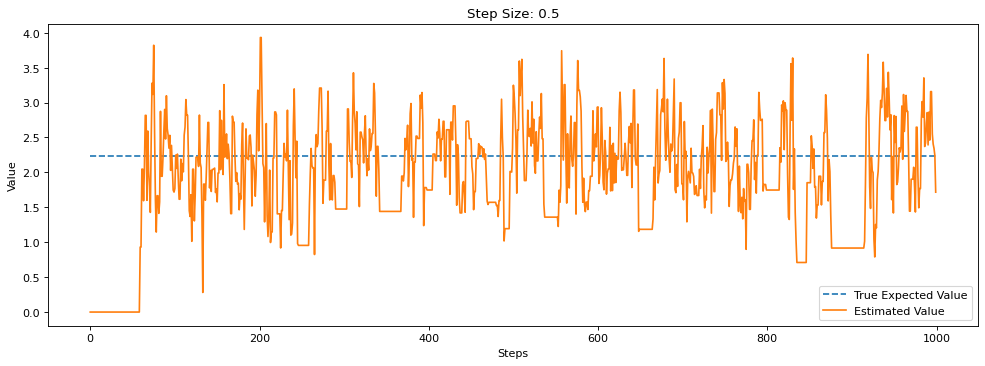

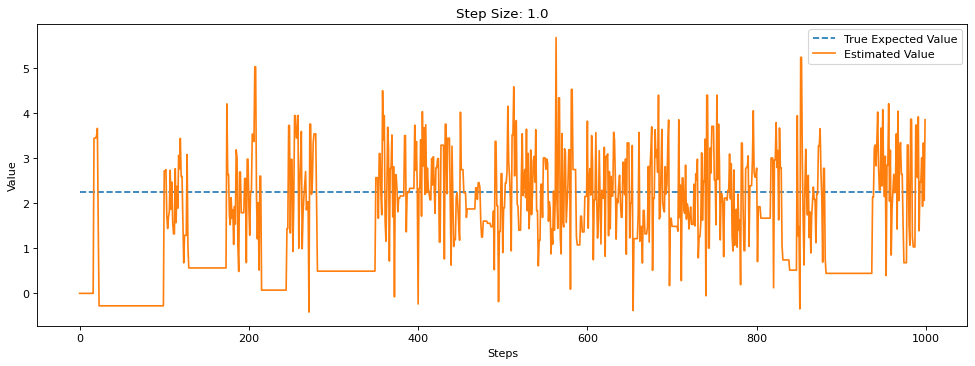

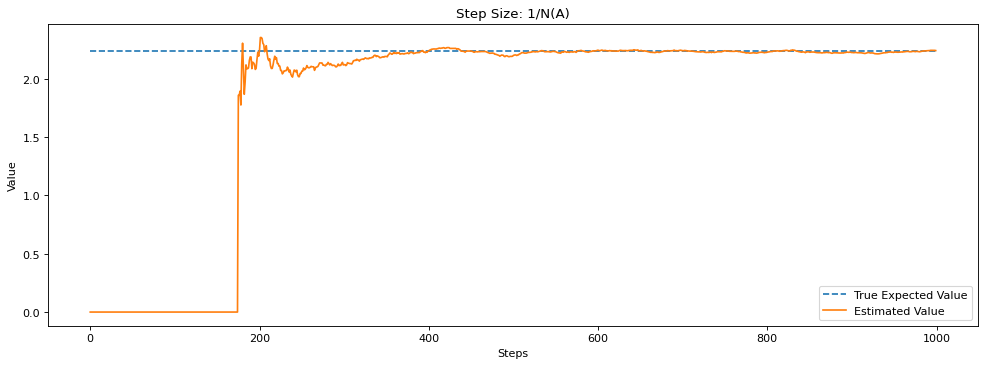

In [34]:
# Plot various step sizes and estimates
largest = 0
num_steps = 1000
for step_size in step_sizes:
    plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
    largest = np.argmax(true_values[step_size])
    plt.plot([true_values[step_size][largest] for _ in range(num_steps)], linestyle="--")
    plt.title("Step Size: {}".format(step_size))
    plt.plot(np.array(q_values[step_size])[:, largest])
    plt.legend(["True Expected Value", "Estimated Value"])
    plt.xlabel("Steps")
    plt.ylabel("Value")
    plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.title("Step Size: 1/N(A)")
plt.plot([true_values[step_size][largest] for _ in range(num_steps)], linestyle="--")
plt.plot(np.array(n_q_values)[:, largest])
plt.legend(["True Expected Value", "Estimated Value"])
plt.xlabel("Steps")
plt.ylabel("Value")
plt.show()

Does this mean that 1/N(A) is always the best? When might it not be? One possible setting where it might not be as effective is in non-stationary problems. You learned about non-stationarity in the lessons. Non-stationarity means that the environment may change over time. This could manifest itself as continual change over time of the environment, or a sudden change in the environment.

Let's look at how a sudden change in the reward distributions affects a step size like 1/N(A). This time we will run the environment for 2000 steps, and after 1000 steps we will randomly change the expected value of all of the arms. We compare two agents, both using epsilon-greedy with epsilon = 0.1. One uses a constant step size of 0.1, the other a step size of 1/N(A) that reduces over time.

100%|██████████| 200/200 [00:05<00:00, 33.85it/s]


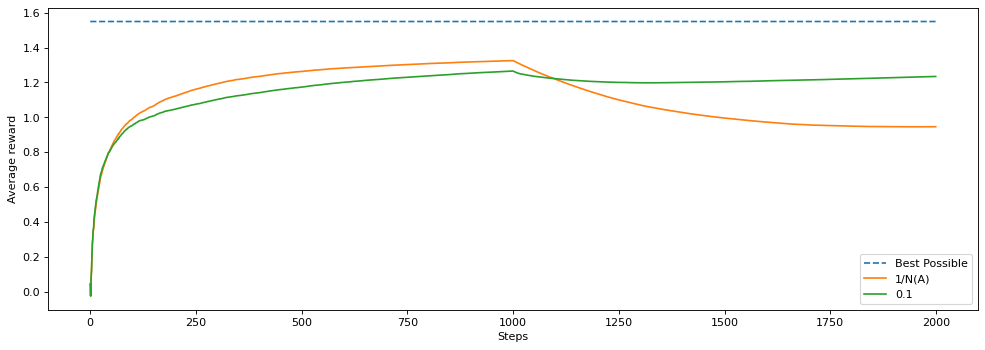

In [36]:
epsilon = 0.1
num_steps = 2000
num_runs = 200
step_size = 0.1

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

for agent in [EpsilonGreedyAgent, EpsilonGreedyAgentWithConstantStepSize]:
    all_averages = []
    for run in tqdm.tqdm(range(num_runs)):
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size}
        env_info = {"random_seed": run}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()

        scores = [0]
        averages = []
        
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if i == 1000:
                rl_glue.environment.arms = np.random.randn(10)
        all_averages.append(averages)
        
    plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Best Possible", "1/N(A)", "0.1"])
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()